# **Capítulo 7: Convergencia y ajuste de modelos**

## Clasificación de imágenes usando la base de datos CIFAR10

Comprobación de acceso a GPU

In [6]:
import torch

# Si disponemos de GPU, la usamos
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Carga y preprocesado de datos

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

tam_batch = 256

# Datos de entrenamiento y validación
trainval_dataset = datasets.CIFAR10(
    root='./datos', # Ruta donde se almacenarán los datos descargados
    train=True,     # Datos de entrenamiento (y validación)
    transform=transforms.ToTensor(), # Conversión más normalización
    download=True   # Se descargan a la carpeta indicada en root
)

# Dividimos los datos de entrenamiento en entrenamiento y validación
train_tam = int(0.8 * len(trainval_dataset))    # 80% para entrenamiento
val_tam = len(trainval_dataset) - train_tam     # 20% para validación
train_dataset, val_dataset = random_split(trainval_dataset,\
                                          [train_tam, val_tam])

# Datos de test
test_dataset = datasets.CIFAR10(
    root='./datos', # Misma ruta que los datos de entrenamiento
    train=False,    # Datos de test
    transform=transforms.ToTensor() # Conversión más normalización
)

# Creamos los dataloaders
train_loader = DataLoader(
    train_dataset,  # Dataset sobre el que iterar
    batch_size=tam_batch,
    shuffle=True    # Se mezclan los datos en cada época de entrenamiento
)
val_loader = DataLoader(
    val_dataset,    # Dataset sobre el que iterar
    batch_size=tam_batch,
    shuffle=False   # Los datos se evalúan siempre en el mismo orden
)
test_loader = DataLoader(
    test_dataset,
    batch_size=tam_batch,
    shuffle=False   # Los datos se evalúan siempre en el mismo orden
)

100%|██████████| 170498071/170498071 [00:12<00:00, 13136274.38it/s]


Extracting ./datos/cifar-10-python.tar.gz to ./datos


Visualización del aspecto de los datos

Tamaño del conjunto de entrenamiento: 40000
Tamaño del conjunto de validación: 10000
Tamaño del conjunto de test: 10000
Tamaño de las imágenes: torch.Size([3, 32, 32])


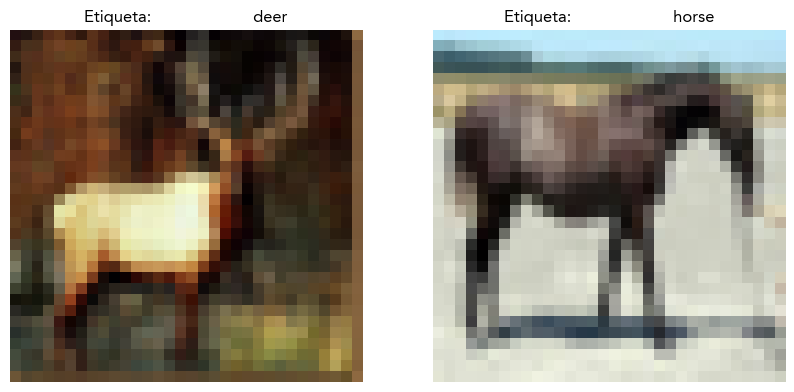

In [11]:
import matplotlib.pyplot as plt

# Dimensiones de los conjuntos de datos
print(f'Tamaño del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Tamaño del conjunto de validación: {len(val_dataset)}')
print(f'Tamaño del conjunto de test: {len(test_dataset)}')

# Obtenemos un lote o batch de imágenes de entrenamiento
imagenes, etiquetas = next(iter(train_loader))
print(f'Tamaño de las imágenes: {imagenes.shape[1:]}')

# Visualizamos las imágenes y etiquetas de un batch de entrenamiento
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2):
    axs[i].imshow(imagenes[i].permute(1, 2, 0))
    axs[i].set_title(f'Etiqueta: \
                     {trainval_dataset.classes[etiquetas[i]]}')
    axs[i].axis('off')
plt.show()

In [12]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, normalizacion=False, dropout=0):
        super(CNN, self).__init__()

        # 1) Bloque extractor de características
        # - Convolución con activación -> Normalización -> Pooling
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding='same')
        if normalizacion:
            self.norm1 = nn.BatchNorm2d(16) # Núm. Canales
        else:
            self.norm1 = nn.Identity()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # - Convolución con activación -> Normalización -> Pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding='same')
        if normalizacion:
            self.norm2 = nn.BatchNorm2d(32) # Núm. Canales
        else:
            self.norm2 = nn.Identity()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # - Dropout
        self.dropout = nn.Dropout(dropout)

        # 2) Bloque clasificador de características
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(32 * 8 * 8, 256)
        self.lin2 = nn.Linear(256, 128)
        self.lin3 = nn.Linear(128, 10)

        # Activaciones:
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.norm2(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        y = self.lin3(x)
        return y

Implementación de la función de entrenamiento

In [13]:
def epoca_train(modelo, train_loader, optimizador,\
                func_perdida, dispositivo, aumentados=None):
    epoca_perdidas = []
    # Iteramos sobre los datos de entrenamiento
    for i, (imagenes, etiquetas) in enumerate(train_loader):
        # Si es posible, transferimos los datos a la GPU
        imagenes = imagenes.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)
        # Aumentado de datos
        if aumentados is not None:
            imagenes = aumentados(imagenes)
        # Ponemos los gradientes a cero
        optimizador.zero_grad()
        # Calculamos las salidas de la red neuronal
        # para las imágenes de entrada
        salidas = modelo(imagenes)
        # Calculamos la pérdida de la red neuronal
        perdida = func_perdida(salidas, etiquetas)
        # Calculamos los gradientes de la pérdida
        # respecto a los parámetros de la red neuronal
        perdida.backward()
        # Actualizamos los parámetros de la red neuronal
        # usando el algoritmo de optimización
        optimizador.step()
        # Añadimos a la lista de pérdidas la pérdida actual
        epoca_perdidas.append(perdida.item())
    # Calculamos la media de las pérdidas para una época
    return sum(epoca_perdidas) / len(epoca_perdidas)

Implementación de la función de test

In [14]:
def epoca_test(modelo, test_loader, dispositivo):
    # Establecemos la red neuronal en modo de evaluación
    modelo.eval()
    # Desactivamos el cálculo de gradientes
    with torch.no_grad():
        correcto = 0
        total = 0
        # Iteramos sobre los datos de test
        for imagenes, etiquetas in test_loader:
            # Si es posible, transferimos los datos a la GPU
            imagenes = imagenes.to(dispositivo)
            etiquetas = etiquetas.to(dispositivo)
            # Calculamos las salidas de la red neuronal
            # para las imágenes de entrada
            salidas = modelo(imagenes)
            # Calculamos las probabilidades de las clases
            salidas = salidas.softmax(dim=1)
            # Obtenemos la clase con mayor probabilidad
            prediccion = salidas.argmax(dim=1)
            # Incrementamos el contador de imágenes procesadas
            total += etiquetas.size(0)
            # Incrementamos el contador de imágenes
            # clasificadas correctamente
            correcto += (prediccion == etiquetas).sum().item()
        # Calculamos la exactitud
        exactitud = 100 * correcto / total
    # Establecemos la red neuronal en modo entrenamiento
    modelo.train()
    return exactitud

Implementación de la función de entrenamiento

In [15]:
def entrenar(modelo, train_loader, val_loader, test_loader,\
             epocas, optimizador, func_perdida, dispositivo,\
             early_stop=False, paciencia=0, aumentados=None):
    # Históricos de valores de pérdida de entrenamiento
    train_perdidas = []
    # Históricos de valores de exactitud de entrenamiento,
    # validación y test
    train_accs, val_accs, test_accs = [], [], []
    # Mejor exactitud de validación
    mejor_val_acc = 0
    # Contador de épocas desde la última mejora en validación
    epocas_desde_mejora = 0

    # Iteramos por cada época
    for epoca in range(epocas):
        # Entrenamos la red neuronal por una época
        train_perdida = epoca_train(modelo, train_loader, optimizador,\
                                    func_perdida, dispositivo)
        train_perdidas.append(train_perdida)
        # Calculamos la exactitud para los datos de entrenamiento
        train_acc = epoca_test(modelo, train_loader, dispositivo)
        train_accs.append(train_acc)
        # Calculamos la exactitud para los datos de validación
        valid_acc = epoca_test(modelo, val_loader, dispositivo)
        val_accs.append(valid_acc)
        # Calculamos la exactitud para los datos de test
        test_acc = epoca_test(modelo, test_loader, dispositivo)
        test_accs.append(test_acc)
        # Sacamos los resultados por pantalla
        print(f'Época {epoca+1}/{epocas},\
        pérdida={train_perdida:.4f},\
        exactitud_train={train_acc:.2f}%,\
        exactitud_val={valid_acc:.2f}%,\
        exactitud_test={test_acc:.2f}%')

        # Early stopping
        if early_stop:
            if valid_acc > mejor_val_acc:
                mejor_val_acc = valid_acc
                epocas_desde_mejora = 0  # Reset
            else:
                epocas_desde_mejora += 1
            # Si la exactitud de validación no mejora tras "paciencia"
            # épocas, paramos el entrenamiento
            if epocas_desde_mejora == paciencia:
                print(f'No se ha mejorado la tasa de acierto en\
                      validación en {paciencia} épocas.')
                break  # Salimos del bucle de las épocas

    # Se ha completado el entrenamiento de la red neuronal
    print('Fin del entrenamiento.')
    return train_perdidas, train_accs, val_accs, test_accs

Definición de los hipérparámetros comúnes a ambos escenarios

In [16]:
epocas = 50
func_perdida = nn.CrossEntropyLoss()

In [17]:
import torch.optim as optim

# Caso base
modelo_base = CNN().to(dispositivo)
optim_base = optim.Adam(modelo_base.parameters())

# Entrenamos el modelo base
metricas_base = entrenar(modelo_base, train_loader, val_loader,\
                         test_loader, epocas, optim_base,\
                         func_perdida, dispositivo)

Época 1/50,        pérdida=1.8341,        exactitud_train=42.40%,        exactitud_val=42.57%,        exactitud_test=42.52%
Época 2/50,        pérdida=1.5110,        exactitud_train=46.52%,        exactitud_val=45.73%,        exactitud_test=46.43%
Época 3/50,        pérdida=1.3718,        exactitud_train=51.63%,        exactitud_val=50.85%,        exactitud_test=51.13%
Época 4/50,        pérdida=1.2596,        exactitud_train=54.81%,        exactitud_val=53.69%,        exactitud_test=53.54%
Época 5/50,        pérdida=1.1486,        exactitud_train=61.94%,        exactitud_val=59.89%,        exactitud_test=59.46%
Época 6/50,        pérdida=1.0673,        exactitud_train=63.64%,        exactitud_val=60.92%,        exactitud_test=61.25%
Época 7/50,        pérdida=1.0016,        exactitud_train=67.78%,        exactitud_val=63.90%,        exactitud_test=63.88%
Época 8/50,        pérdida=0.9183,        exactitud_train=68.98%,        exactitud_val=64.07%,        exactitud_test=63.97%
Época 9/

Definición y visualización de los aumentados empleados en el caso avanzado

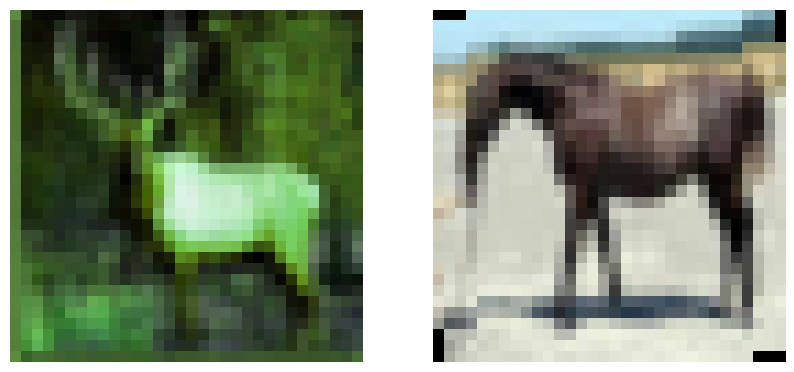

In [28]:
aumentados = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(nn.ModuleList(
        [transforms.ColorJitter(brightness=0.2, hue=0.2)]), p=0.1)])

# Visualizamos las imágenes aumentadas de un batch de entrenamiento
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2):
    axs[i].imshow(aumentados(imagenes[i]).permute(1, 2, 0))
    axs[i].axis('off')
plt.show()

Entrenamiento del caso avanzado

In [29]:
# Caso avanzado
modelo_avan = CNN(normalizacion=True, dropout=0.5).to(dispositivo)
optim_avan = optim.Adam(modelo_avan.parameters())

# Entrenamos el modelo avanzado
metricas_avan = entrenar(modelo_avan, train_loader, val_loader,\
                         test_loader, epocas, optim_avan,\
                         func_perdida, dispositivo, early_stop=True,\
                         paciencia=5, aumentados=aumentados)

Época 1/50,        pérdida=1.4299,        exactitud_train=57.55%,        exactitud_val=55.13%,        exactitud_test=55.39%
Época 2/50,        pérdida=1.1031,        exactitud_train=65.68%,        exactitud_val=62.54%,        exactitud_test=62.62%
Época 3/50,        pérdida=0.9591,        exactitud_train=57.88%,        exactitud_val=54.35%,        exactitud_test=54.48%
Época 4/50,        pérdida=0.8403,        exactitud_train=75.97%,        exactitud_val=68.59%,        exactitud_test=68.13%
Época 5/50,        pérdida=0.7635,        exactitud_train=78.72%,        exactitud_val=69.29%,        exactitud_test=68.52%
Época 6/50,        pérdida=0.6872,        exactitud_train=77.06%,        exactitud_val=67.50%,        exactitud_test=66.67%
Época 7/50,        pérdida=0.6289,        exactitud_train=84.19%,        exactitud_val=71.34%,        exactitud_test=70.66%
Época 8/50,        pérdida=0.5797,        exactitud_train=85.96%,        exactitud_val=71.66%,        exactitud_test=71.33%
Época 9/

Comparación entre el caso base y el caso avanzado

Exactitud de test del modelo base: 68.67%
Exactitud de test del modelo avanzado: 71.92%


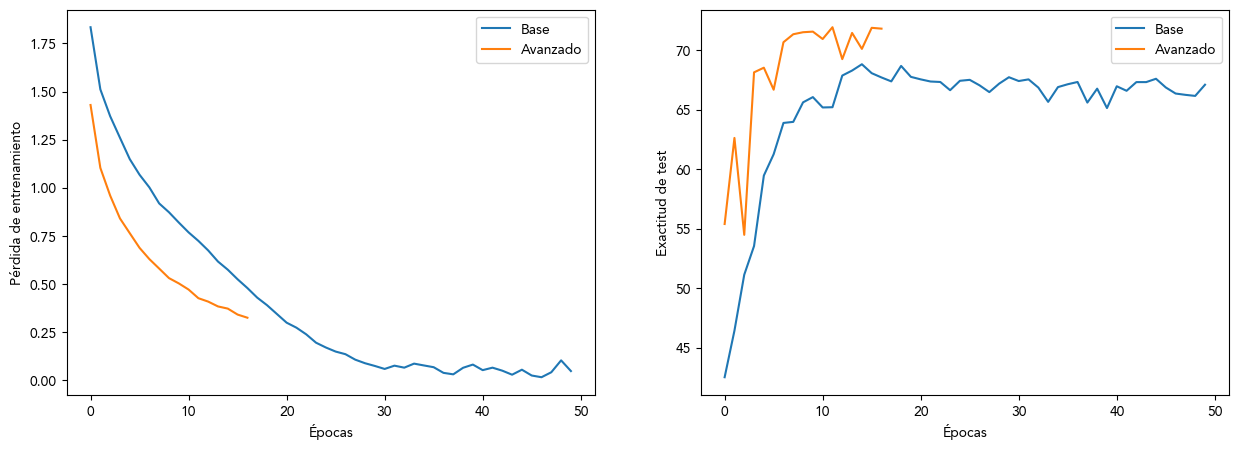

In [33]:
import numpy as np

# Calcular la exactitud de test en función de la mejor exactitud de validación
def test_acc_from_best_val_acc(metricas):
    # Obtenemos la época asociada a la mejor exactitud de validación
    epoca = np.argmax(metricas[2])
    # Devolvemos la exactitud de test de esa época
    return metricas[3][epoca]

# Exactitud de test del modelo base
test_acc_base = test_acc_from_best_val_acc(metricas_base)
print(f'Exactitud de test del modelo base: {test_acc_base:.2f}%')

# Exactitud de test del modelo avanzado
test_acc_avan = test_acc_from_best_val_acc(metricas_avan)
print(f'Exactitud de test del modelo avanzado: {test_acc_avan:.2f}%')

# Visualizamos la perdida de entrenamiento y la exactitud de test
# a lo largo de las épocas para ambos modelos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
res_comp = {'Pérdida de entrenamiento': 0, 'Exactitud de test': -1}
for i, (k, v) in enumerate(res_comp.items()):
    axs[i].plot(metricas_base[v], label='Base')
    axs[i].plot(metricas_avan[v], label='Avanzado')
    axs[i].set_xlabel('Épocas')
    axs[i].set_ylabel(k)
    axs[i].legend()
plt.show()

Cálculo de la época de paso del modelo avanzado

In [34]:
dif_epoca = np.argmax(metricas_avan[-1] > np.max(metricas_base[-1]))
print(dif_epoca)

6


In [36]:
np.argmax(metricas_base[-2])

18